In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

from GridCal.Engine import Bus, Load, Line, Generator, MultiCircuit
from GridCal.Engine import PowerFlowOptions, PowerFlowDriver, SolverType

np.set_printoptions(precision=4)

Bentayga is not available
Newton native unavailable


In [3]:
grid = MultiCircuit()

# Add the buses and the generators and loads attached
bus1 = Bus('Bus 1', vnom=20)
# bus1.is_slack = True
grid.add_bus(bus1)

gen1 = Generator('Slack Generator', voltage_module=1.0)
grid.add_generator(bus1, gen1)

bus2 = Bus('Bus 2', vnom=20)
grid.add_bus(bus2)
grid.add_load(bus2, Load('load 2', P=40, Q=20))

bus3 = Bus('Bus 3', vnom=20)
grid.add_bus(bus3)
grid.add_load(bus3, Load('load 3', P=25, Q=15))

bus4 = Bus('Bus 4', vnom=20)
grid.add_bus(bus4)
grid.add_load(bus4, Load('load 4', P=40, Q=20))

bus5 = Bus('Bus 5', vnom=20)
grid.add_bus(bus5)
grid.add_load(bus5, Load('load 5', P=50, Q=20))

# add branches (Lines in this case)
grid.add_line(Line(bus1, bus2, 'line 1-2', r=0.05, x=0.11, b=0.02))
grid.add_line(Line(bus1, bus3, 'line 1-3', r=0.05, x=0.11, b=0.02))
grid.add_line(Line(bus1, bus5, 'line 1-5', r=0.03, x=0.08, b=0.02))
grid.add_line(Line(bus2, bus3, 'line 2-3', r=0.04, x=0.09, b=0.02))
grid.add_line(Line(bus2, bus5, 'line 2-5', r=0.04, x=0.09, b=0.02))
grid.add_line(Line(bus3, bus4, 'line 3-4', r=0.06, x=0.13, b=0.03))
grid.add_line(Line(bus4, bus5, 'line 4-5', r=0.04, x=0.09, b=0.02))

In [4]:
options = PowerFlowOptions(SolverType.NR, verbose=False)
power_flow = PowerFlowDriver(grid, options)
power_flow.run()

In [5]:
print('|V|:', abs(power_flow.results.voltage))
print('|Sbranch|:', abs(power_flow.results.Sf))
print('|loading|:', abs(power_flow.results.loading) * 100)
print('err:', power_flow.results.error)
print('Conv:', power_flow.results.converged)
print('Total real losses:', sum(np.real(power_flow.results.losses)))
print('Power flow:', power_flow.results.If)

|V|: [1.     0.9553 0.9548 0.9333 0.9534]
|Sbranch|: [49.8051 49.6978 76.058   0.464   5.0627 19.6677 24.6214]
|loading|: [4980.5128 4969.7819 7605.7981   46.4042  506.2687 1966.7722 2462.1446]
err: 1.8965827353056852e-08
Conv: True
Total real losses: 4.818058112289158
Power flow: [ 0.458 -0.1958j  0.4542-0.2017j  0.686 -0.3284j -0.0042+0.0024j  0.0522+0.009j   0.1937-0.0701j -0.2219+0.1427j]


In [6]:
import matplotlib.pyplot as plt
import networkx as nx

%matplotlib inline

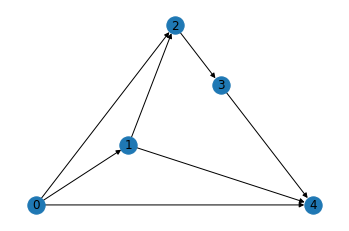

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)

if grid.graph is None:
    grid.build_graph()

nx.draw(grid.graph, pos=nx.planar_layout(grid.graph), ax=ax, with_labels=True)

In [8]:
import networkx as nx


def build_graph_real_power_flow(grid, current_flow):
    graph_real_power_flow = nx.DiGraph()

    current_flow_direction = np.real(current_flow) > 0

    for branch_list in grid.get_branch_lists():
        for direction, branch in zip(current_flow_direction, branch_list):
            f = grid.bus_dictionary[branch.bus_from.idtag]
            t = grid.bus_dictionary[branch.bus_to.idtag]
            if direction:
                graph_real_power_flow.add_edge(f, t)
            else:
                graph_real_power_flow.add_edge(t, f)
    return graph_real_power_flow

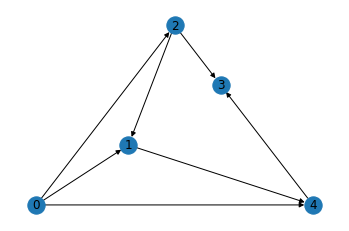

In [10]:
graph_real_power_flow = build_graph_real_power_flow(grid, power_flow.results.If)


fig = plt.figure()
ax = fig.add_subplot(111)
nx.draw(graph_real_power_flow, pos=nx.planar_layout(grid.graph), ax=ax, with_labels=True)